To Do list:
- Merge Create DB notebook to this notebook, so it is all pre-packaged for professor
    - Make sure to include the create pos_trans_wtob querires/ code

- convert to .py and clean-up 
    - jupyter nbconvert notebook.ipynb --to script

In [1]:
# Import Libraries
import sqlite3
import pandas as pd
import numpy as np
import matplotlib as mpl, matplotlib.pyplot as plt
%matplotlib inline

## Prep -- Create DB from Source Files

In [2]:
# to be added

## Prep -- Get Data from SQLite DB and Prepare Dataframes

In [3]:
# Set DB Connection and cursor
db = sqlite3.connect('C:/Users/TheCu/OneDrive/Documents/Grad-School-Docs/Foundations-of-DM/Data/ABCPharmacy/ABC_PharmacyDB.sqlite')

In [4]:
# Get data from pos_trans_wTOB for sales that are not tobacco
sales_notTob_qry = """SELECT pm.PHRMCY_NAM, ptwt.phrmcy_nbr, ptwt.prod_nbr, (ptwt.ext_sls_amt * ptwt.sls_qty) as lineTotal 
FROM pos_trans_wTob ptwt 
JOIN phrmcy_master pm ON pm.phrmcy_nbr = ptwt.phrmcy_nbr
WHERE ptwt.is_tob = 0;
"""
sales_notTob = pd.read_sql_query(sales_notTob_qry, db)

# Add sales total calculated field and group by pharmacy 
#sales_notTob["sls_sum"] = sales_notTob["ext_sls_amt"] * sales_notTob["sls_qty"]
sales_notTob = sales_notTob.groupby(by = ["PHRMCY_NAM"]).sum()
sales_notTob = sales_notTob.rename(columns={"lineTotal": "notTobSales"})

# Get data from pos_trans_wTOB for sales that are tobacco
sales_isTob_qry = """SELECT pm.PHRMCY_NAM, ptwt.phrmcy_nbr, ptwt.prod_nbr, (ptwt.ext_sls_amt * ptwt.sls_qty) as lineTotal 
FROM pos_trans_wTob ptwt 
JOIN phrmcy_master pm ON pm.phrmcy_nbr = ptwt.phrmcy_nbr
WHERE ptwt.is_tob = 1;
"""
sales_isTob = pd.read_sql_query(sales_isTob_qry, db)

# Add sales total calculated field and group by pharmacy 
#sales_isTob["sls_sum"] = sales_isTob["ext_sls_amt"] * sales_isTob["sls_qty"]
sales_isTob = sales_isTob.groupby(by = ["PHRMCY_NAM"]).sum()
sales_isTob = sales_isTob.rename(columns={"lineTotal": "tobSales"})

# Get data for items bought with tobacco
bkstsWTob_qry = """SELECT phm.PHRMCY_NAM, phm.phrmcy_nbr, phm.st_cd, ptwt.sales_id, ptwt.bskt_id, ptwt.sls_dte_nbr, ptwt.prod_nbr,
(ptwt.sls_qty * ptwt.ext_sls_amt) AS lineTotal,
pm.PROD_DESC, psc.sub_cat_desc, mpc.major_cat_desc
FROM pos_trans_wTob ptwt
JOIN prod_master pm ON pm.PROD_NBR = ptwt.prod_nbr
JOIN phrmcy_master phm ON phm.phrmcy_nbr = ptwt.phrmcy_nbr
JOIN prod_seg ps ON ps.seg_cd = pm.SEGMENT_CD
JOIN prod_sub_cat psc on psc.sub_cat_cd = ps.sub_cat_cd
JOIN prod_cat pc on pc.cat_cd = psc.cat_cd
JOIN major_prod_cat mpc on mpc.major_cat_cd = pc.major_cat_cd
WHERE ptwt.bskt_id IN (SELECT DISTINCT ptwt.bskt_id
FROM  pos_trans_wTob ptwt
WHERE is_tob = 1)
AND is_tob = 0
ORDER by ptwt.bskt_id ASC, sls_dte_nbr;
"""
bkstsWTob = pd.read_sql_query(bkstsWTob_qry, db)

# Get pharmacy location data
phrmcyLoc_qry = """SELECT pm.PHRMCY_NAM, pm.st_cd, pm.zip_3_cd 
FROM phrmcy_master pm
GROUP BY pm.PHRMCY_NAM;
"""
phrmcyLoc = pd.read_sql_query(phrmcyLoc_qry, db)

In [5]:
# create assoc. items subset dataframe
assocItems = bkstsWTob
assocItems = assocItems[["PHRMCY_NAM", "phrmcy_nbr","lineTotal"]].copy()
assocItems = assocItems.rename(columns={"lineTotal": "assocItemSales"})
assocItems = assocItems.groupby(by = ["PHRMCY_NAM"]).sum()

In [6]:
# join data frames
sales_sum = pd.merge(sales_notTob, sales_isTob, left_index=True, right_index=True, how='outer')

# refactor - join assoc. items
sales_sum = pd.merge(sales_sum, assocItems, left_index=True, right_index=True, how='outer')

#reduce fields
sales_sum = sales_sum[["notTobSales", "tobSales","assocItemSales"]].copy()

# replace NaN
sales_sum['tobSales'] = sales_sum['tobSales'].fillna(0)
sales_sum['assocItemSales'] = sales_sum['assocItemSales'].fillna(0)

# remove assoc. items from Not_tob totals
sales_sum['notTobSales'] = sales_sum['notTobSales'] - sales_sum['assocItemSales']

# add total revenue
sales_sum['totalRevenue'] = sales_sum['notTobSales'].fillna(0) + sales_sum['tobSales'] + sales_sum['assocItemSales']

# add percent fields
sales_sum["perNotTob"] = (sales_sum["notTobSales"] / sales_sum['totalRevenue'])
sales_sum["perTob"] = (sales_sum["tobSales"] / sales_sum['totalRevenue'])
sales_sum["perAssocItems"]  = (sales_sum["assocItemSales"] / sales_sum['totalRevenue'])

## Section 1 -- Tobacco and Cigarette Sales Impact to Overall Revenue and Profit

In [7]:
# Calculate High Level Overall Revenue Stats
allSalesTotal = round(sales_sum["totalRevenue"].sum(skipna=True))
notTob_salesTotal = round(sales_sum["notTobSales"].sum(skipna=True))
isTob_salesTotal = round(sales_sum["tobSales"].sum(skipna=True))
assocItem_salesTotal = round(sales_sum["assocItemSales"].sum(skipna=True))  
percentTob = round((isTob_salesTotal / allSalesTotal)*100,1)
percentTobwAssoc = round(((isTob_salesTotal + assocItem_salesTotal) / allSalesTotal)*100,1)

# Add Revenue Variables to list
revList = pd.Series(["Revenue", allSalesTotal, notTob_salesTotal, isTob_salesTotal, assocItem_salesTotal, percentTob, percentTobwAssoc])



In [8]:
# Calculate High Level Overall Profit Stats

# Set Margins - Based on sources cited in report
overallProfMarg = 0.218
tobProfMarg = 0.161

# Calculate Profit Stats
overallProfit = round(allSalesTotal * overallProfMarg)
notTobProfit = round(notTob_salesTotal * overallProfMarg)
tobProfit = round(isTob_salesTotal * tobProfMarg)
assocItemProfit = round(assocItem_salesTotal * overallProfMarg)
percentProfTob = round((tobProfit / overallProfit)*100,1)
percentProfTobwAssoc = round(((tobProfit + assocItemProfit) / overallProfit)*100,1)

# Add Profit Variables to list
profList = pd.Series(["Profit",overallProfit,notTobProfit,tobProfit, assocItemProfit, percentProfTob, percentProfTobwAssoc])



In [9]:
#Merge Lists in Dataframe
revProfReport = pd.DataFrame([list(revList), list(profList)],
                             columns =  ["Type", "Overall Total", "Not Tobacco Total", "Tobacco Total", "Assoc. Item Total",
                                         "Percent of Tobacco", "Percent of Tobacco w/ Assoc. Item"])
# Print Report
revProfReport

,Type,Overall Total,Not Tobacco Total,Tobacco Total,Assoc. Item Total,Percent of Tobacco,Percent of Tobacco w/ Assoc. Item
0,Revenue,17283853,16519000,677874,86979,3.9,4.4
1,Profit,3767880,3601142,109138,18961,2.9,3.4


In [10]:
#Calculate Profit Losses
lostProf = (tobProfit + assocItemProfit)
perOfProfLost = round((lostProf/overallProfit)*100,1)
newOverallProf = notTobProfit


#Print Report
print("Profit Loss Report:")
print(f"Projected profit reduction for six months: $",lostProf)
print(f"Percent of profit lost:",perOfProfLost)
print(f"New projected six month profit: $", newOverallProf)
print()

Profit Loss Report:
Projected profit reduction for six months: $ 128099
Percent of profit lost: 3.4
New projected six month profit: $ 3601142



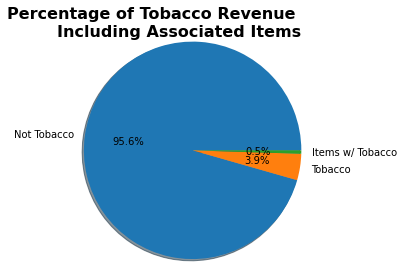

In [11]:
# Percent of total revenue pie chart
salesTotalList = ([notTob_salesTotal,isTob_salesTotal,assocItem_salesTotal])
labels = ["Not Tobacco", "Tobacco","Items w/ Tobacco"]

plt.pie(salesTotalList, labels = labels,
        autopct='%1.1f%%', shadow = True, radius=1.25)
plt.title('Percentage of Tobacco Revenue \nIncluding Associated Items', fontsize = 16, fontweight = "bold", loc="right")
plt.show()

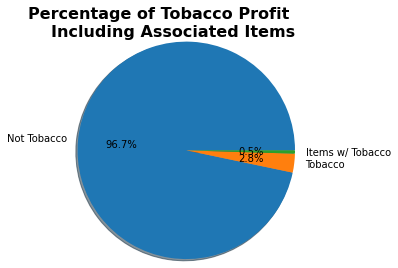

In [12]:
# add profit pie chart
# Percent of total revenue pie chart
profitTotalList = ([overallProfit,tobProfit,assocItemProfit ])
labels = ["Not Tobacco", "Tobacco","Items w/ Tobacco"]

plt.pie(profitTotalList, labels = labels,
        autopct='%1.1f%%', shadow = True, radius=1.25)
plt.title('Percentage of Tobacco Profit \nIncluding Associated Items', fontsize = 16, fontweight = "bold", loc="right")
plt.show()

## Section 2 -- Branch Level Impacts

In [13]:
# Show # of Branches that Do/ Do Not Sell Tobacco
# REVISIT -- don't like that I do this two different ways

numBranch_total = len(sales_sum)
numBranch_noTob = len(sales_sum[sales_sum['tobSales'] == 0])
numBranch_wTob = len(sales_sum[sales_sum['tobSales'] > 0])

print ("Branches with and without tobacco sales:")
print(f"The total number of ABC Pharmacy branches:",numBranch_total)
print(f"The total number of ABC Pharmacy branches that do not sell tobacco:",numBranch_noTob)
print(f"The total number of ABC Pharmacy branches that do sell tobacco:", numBranch_wTob)
print()

Branches with and without tobacco sales:
The total number of ABC Pharmacy branches: 106
The total number of ABC Pharmacy branches that do not sell tobacco: 79
The total number of ABC Pharmacy branches that do sell tobacco: 27



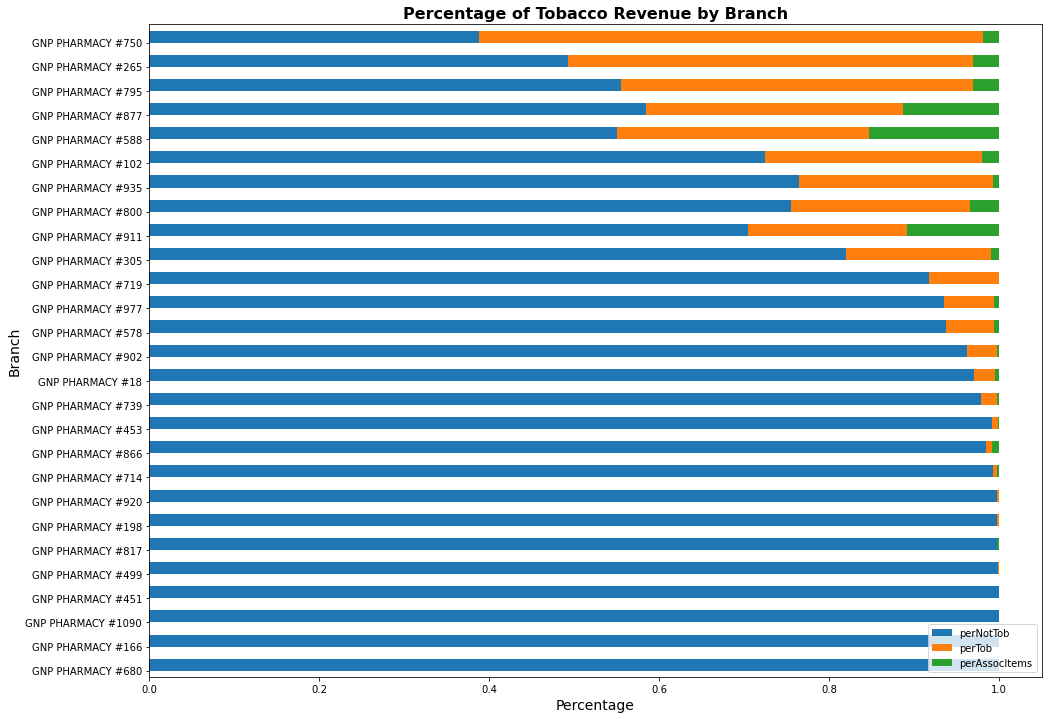

In [14]:
# Prep for bar chart display - subset to branches that sell tobacco & group by 
bl_sales_sum = sales_sum[["perNotTob", "perTob", "perAssocItems"]].copy()

bl_sales_sum = bl_sales_sum[bl_sales_sum['perTob'] > 0]
bl_sales_sum.sort_values(by=['perTob'], inplace = True, ascending= True)

bl_sales_sum.plot(kind ='barh', stacked = 'true', 
                  align ='edge', figsize = (16, 12))
plt.title('Percentage of Tobacco Revenue by Branch', fontsize = 16, fontweight = "bold")
plt.xlabel('Percentage', fontsize = 14)
plt.ylabel('Branch', fontsize = 14)
plt.legend(loc='lower right')
plt.show()

### Categorize Branches

In [15]:
# assign risk level based on conditions
atRiskBranch = sales_sum

# Classify Risk Category based on % of Rev
medPerLower = 0.782
lowPerLower = 0.95

riskPerConditions = [
    (atRiskBranch['perTob'] == 0),
    (atRiskBranch['perNotTob'] < medPerLower),
    (atRiskBranch['perNotTob'] < lowPerLower) & (atRiskBranch['perNotTob'] > medPerLower),
    (atRiskBranch['perNotTob'] > lowPerLower),
]
riskPerCat = ['0 - No Risk','3 - High', '2 - Medium', '1 - Low']

atRiskBranch['riskLevel'] = np.select(riskPerConditions, riskPerCat)

# Repot Risk Counts
countHighRisk = len(atRiskBranch[atRiskBranch['riskLevel'] == '3 - High']) 
countMedRisk = len(atRiskBranch[atRiskBranch['riskLevel'] == '2 - Medium']) 
countHLowRisk = len(atRiskBranch[atRiskBranch['riskLevel'] == '1 - Low'])
countNoRisk = len(atRiskBranch[atRiskBranch['riskLevel'] == '0 - No Risk'])

print("Branch Risk Categorizations:")
print(f"Number of high risk branches as defined by percent of revenue over", round((1-medPerLower)*100,1),
      "% is:", countHighRisk)
print(f"Number of medium risk branches as defined by percent of revenue over", round((1-lowPerLower)*100,1),
      "% but lower than",round((1-medPerLower)*100,1),"% is:",countMedRisk)
print(f"Number of low risk branches as defined by percent of revenue less than",round((1-lowPerLower)*100,1),
      "is:",countHLowRisk)
print(f"Number of no risk branches that do not sell tobacco is: ", countNoRisk)
print()

Branch Risk Categorizations:
Number of high risk branches as defined by percent of revenue over 21.8 % is: 9
Number of medium risk branches as defined by percent of revenue over 5.0 % but lower than 21.8 % is: 4
Number of low risk branches as defined by percent of revenue less than 5.0 is: 14
Number of no risk branches that do not sell tobacco is:  79



In [16]:
# Prepare Risk Summary
atRiskBranchSummary = atRiskBranch
atRiskBranchSummary = atRiskBranch[['notTobSales','tobSales','assocItemSales','riskLevel']].copy()
atRiskBranchSummary['revenueSum'] = round(atRiskBranchSummary['notTobSales'] + atRiskBranchSummary['tobSales'] + atRiskBranchSummary['assocItemSales'])
atRiskBranchSummary = atRiskBranchSummary.groupby(by = ["riskLevel"]).sum()

# Round Fields
atRiskBranchSummary['notTobSales'] = round(atRiskBranchSummary['notTobSales'])
atRiskBranchSummary['tobSales'] = round(atRiskBranchSummary['tobSales'])
atRiskBranchSummary['assocItemSales'] = round(atRiskBranchSummary['assocItemSales'])

# Add Calculated Fields
atRiskBranchSummary['revenuePercent'] = round((atRiskBranchSummary['revenueSum']/allSalesTotal*100),1) 
atRiskBranchSummary['notTabPer'] = round((atRiskBranchSummary['notTobSales']/ atRiskBranchSummary['revenueSum']*100),1)
atRiskBranchSummary['tobPer'] = round((atRiskBranchSummary['tobSales']/ atRiskBranchSummary['revenueSum']*100),1)
atRiskBranchSummary['assocItemPer'] = round((atRiskBranchSummary['assocItemSales']/ atRiskBranchSummary['revenueSum']*100),1)

#Format Display
atRiskBranchSummary


,notTobSales,tobSales,assocItemSales,revenueSum,revenuePercent,notTabPer,tobPer,assocItemPer
riskLevel,,,,,,,,
0 - No Risk,9162714.0,0.0,0.0,9162718.0,53.0,100.0,0.0,0.0
1 - Low,5951248.0,40902.0,7244.0,5999394.0,34.7,99.2,0.7,0.1
2 - Medium,602817.0,66523.0,4075.0,673415.0,3.9,89.5,9.9,0.6
3 - High,802220.0,570449.0,75659.0,1448330.0,8.4,55.4,39.4,5.2


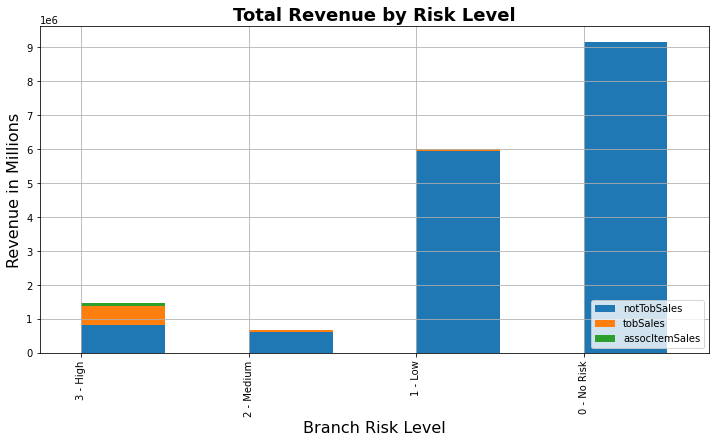

In [17]:
# Prep for bar chart display - subset to branches that sell tobacco & group by
rl_sales_sum = atRiskBranch[['notTobSales','tobSales','assocItemSales','riskLevel']].copy()
rl_sales_sum = rl_sales_sum.groupby(by = ["riskLevel"]).sum()
rl_sales_sum.sort_values(by=['riskLevel'], inplace = True, ascending= False)

#Display bar chart
rl_sales_sum.plot(kind ='bar', stacked = 'true',
                   align ='edge', figsize = (12, 6))
plt.title('Total Revenue by Risk Level', fontsize = 18, fontweight = "bold")
plt.xlabel('Branch Risk Level', fontsize = 16)
plt.ylabel('Revenue in Millions', fontsize = 16)
plt.yticks(np.arange(0, 10000000, 1000000))
plt.grid()
plt.legend(loc='lower right')
plt.show()

### Deep Dive into High Risk Branches

In [18]:
#Merge Dataframes
phrmcyLoc.set_index(["PHRMCY_NAM"], inplace = True)
highRiskBranch = atRiskBranch[atRiskBranch['riskLevel'] == '3 - High']
highRiskBranch = pd.merge(highRiskBranch, phrmcyLoc, left_index=True, right_index=True, how='left')

In [19]:
#Prepare Summary Report
highRiskBranch= highRiskBranch[["notTobSales","tobSales","assocItemSales", "totalRevenue", "perNotTob", "perTob", "perAssocItems", "st_cd"]].copy()
highRiskBranch['perNotTob'] = round(highRiskBranch['perNotTob']*100,1)
highRiskBranch['perTob'] = round(highRiskBranch['perTob']*100,1)
highRiskBranch['perAssocItems'] = round(highRiskBranch['perAssocItems']*100,1)
highRiskBranch.sort_values(by=['perNotTob'], inplace = True, ascending= False)

# Round Fields
highRiskBranch['notTobSales'] = round(highRiskBranch['notTobSales'])
highRiskBranch['tobSales'] = round(highRiskBranch['tobSales'])
highRiskBranch['assocItemSales'] = round(highRiskBranch['assocItemSales'])
highRiskBranch['totalRevenue'] = round(highRiskBranch['totalRevenue'])

highRiskBranch

,notTobSales,tobSales,assocItemSales,totalRevenue,perNotTob,perTob,perAssocItems,st_cd
PHRMCY_NAM,,,,,,,,
GNP PHARMACY #935,83768.0,24939.0,849.0,109556.0,76.5,22.8,0.8,NY
GNP PHARMACY #800,1829.0,510.0,82.0,2421.0,75.5,21.1,3.4,ME
GNP PHARMACY #102,84461.0,29834.0,2308.0,116604.0,72.4,25.6,2.0,NY
GNP PHARMACY #911,39525.0,10484.0,6088.0,56096.0,70.5,18.7,10.9,CT
GNP PHARMACY #877,50001.0,25757.0,9704.0,85462.0,58.5,30.1,11.4,CT
GNP PHARMACY #795,288139.0,215068.0,16302.0,519509.0,55.5,41.4,3.1,NJ
GNP PHARMACY #588,120771.0,65145.0,33597.0,219513.0,55.0,29.7,15.3,CT
GNP PHARMACY #265,8859.0,8554.0,552.0,17965.0,49.3,47.6,3.1,NJ
GNP PHARMACY #750,124868.0,190159.0,6177.0,321204.0,38.9,59.2,1.9,NJ


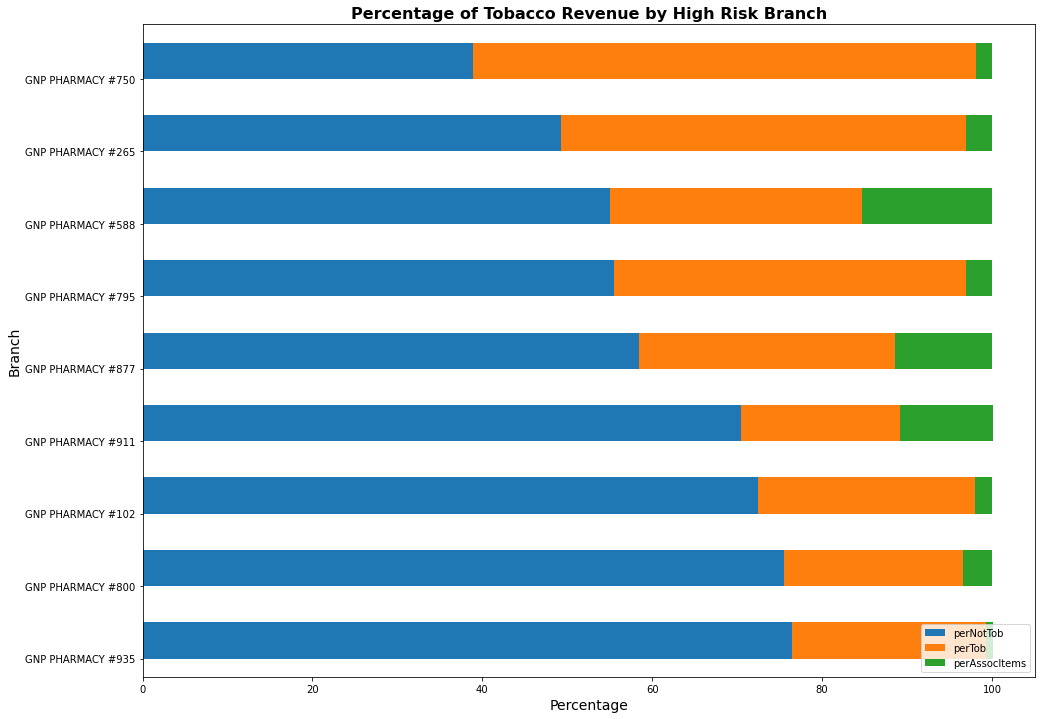

In [20]:
# Prep for bar chart display - subset to branches that sell tobacco & group by 
highRiskSalesPlot = highRiskBranch[["perNotTob", "perTob", "perAssocItems"]].copy()

highRiskSalesPlot = highRiskSalesPlot[highRiskSalesPlot['perTob'] >= 0.218]
highRiskSalesPlot.sort_values(by=['perNotTob'], inplace = True, ascending= False)

highRiskSalesPlot.plot(kind ='barh', stacked = 'true', 
                  align ='edge', figsize = (16, 12))
plt.title('Percentage of Tobacco Revenue by High Risk Branch', fontsize = 16, fontweight = "bold")
plt.xlabel('Percentage', fontsize = 14)
plt.ylabel('Branch', fontsize = 14)
plt.legend(loc='lower right')
plt.show()

In [21]:
# High Risk Branch Profits

# prepare dataframe 
highRiskBranchProfit = highRiskBranch
highRiskBranchProfit= highRiskBranchProfit[["notTobSales","tobSales","assocItemSales","totalRevenue"]].copy()

# Calculate Current Profit
highRiskBranchProfit['ProfitFromTob'] = highRiskBranchProfit['tobSales'] * tobProfMarg
highRiskBranchProfit['ProfitFromAssocItems'] = highRiskBranchProfit['assocItemSales'] * overallProfMarg
highRiskBranchProfit['ProfitFromNotTob'] = highRiskBranchProfit['notTobSales'] * overallProfMarg
highRiskBranchProfit['CurrentBranchProfit'] = round(highRiskBranchProfit['ProfitFromTob'] + highRiskBranchProfit['ProfitFromAssocItems'] + highRiskBranchProfit['ProfitFromNotTob']) 

#Calculate New Profit
highRiskBranchProfit['NewProfit'] = round(highRiskBranchProfit['ProfitFromNotTob'])

#format and display report
highRiskBranchProfit = highRiskBranchProfit[["CurrentBranchProfit","NewProfit"]].copy()
highRiskBranchProfit.sort_values(by=['NewProfit'], inplace = True, ascending= True)
highRiskBranchProfit

,CurrentBranchProfit,NewProfit
PHRMCY_NAM,,
GNP PHARMACY #800,499.0,399.0
GNP PHARMACY #265,3429.0,1931.0
GNP PHARMACY #911,11632.0,8616.0
GNP PHARMACY #877,17163.0,10900.0
GNP PHARMACY #935,22462.0,18261.0
GNP PHARMACY #102,23719.0,18412.0
GNP PHARMACY #588,44141.0,26328.0
GNP PHARMACY #750,59183.0,27221.0
GNP PHARMACY #795,100994.0,62814.0


In [22]:
#Calculate Profit for High Risk Branches
highRiskCurrentProfit = round(highRiskBranchProfit["CurrentBranchProfit"].sum())
highRiskCurrentPer = round((highRiskCurrentProfit/overallProfit)*100,1)

#Calculate Updated Profit for High Risk Braches
highRiskNewProfit = round(highRiskBranchProfit["NewProfit"].sum())
highRiskNewPer = round((highRiskNewProfit/overallProfit)*100,1)

#Calculate Diffs
diffProfit = round(highRiskCurrentProfit - highRiskNewProfit)
diffProfitPer = round((highRiskCurrentPer - highRiskNewPer),1)

#Print Report
print("Profit impact from High Risk Branches:")
print(f"Sum of current profit for High Risk Branches is $",highRiskCurrentProfit, "which accounts for",
      highRiskCurrentPer,"% of overall profit")
print(f"Sum of projected new profit for High Risk Branches is $",highRiskNewProfit, "which accounts for",
      highRiskNewPer,"% of overall profit")
print(f"This represents a loss of $", diffProfit, "and", diffProfitPer, "% in profit" )
print()

Profit impact from High Risk Branches:
Sum of current profit for High Risk Branches is $ 283222 which accounts for 7.5 % of overall profit
Sum of projected new profit for High Risk Branches is $ 174882 which accounts for 4.6 % of overall profit
This represents a loss of $ 108340 and 2.9 % in profit



## Section 3 -- Associated Item Sales

In [23]:
# items sold most frequently with tobacco

# prepare dataframe
itemsWTob = bkstsWTob
itemsWTob = itemsWTob[itemsWTob['lineTotal'] > 0]
itemsWTob= itemsWTob[["sub_cat_desc","lineTotal"]].copy()

# Group and Sum by Subcategory
itemsWTob = itemsWTob.groupby(by = ["sub_cat_desc"],as_index=False).sum()

# prepare and display
itemsWTob.sort_values(by=['lineTotal'], inplace = True, ascending= True)
itemsWTob['lineTotal'].describe()

count      161.000000
mean       540.241925
std       3209.523651
min          1.830000
25%         23.460000
50%         78.310000
75%        250.720000
max      40107.000000
Name: lineTotal, dtype: float64

<function matplotlib.pyplot.show(close=None, block=None)>

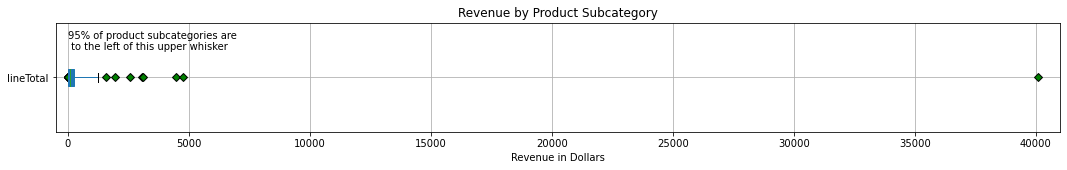

In [24]:
# Create Boxplot of Subcategory Revenue
green_diamond = dict(markerfacecolor='g', marker='D')
#flierprops = dict(marker='o', markerfacecolor='green', markersize=12,
                 # markeredgecolor='none')

# flierprops=flierprops

boxplot = itemsWTob.boxplot(column='lineTotal',vert=False, autorange=False, figsize = (18,2), whis=[5, 95], patch_artist=True, flierprops=green_diamond)
plt.xlim([-500, 41000])
plt.title("Revenue by Product Subcategory")
plt.xlabel("Revenue in Dollars")
plt.annotate("95% of product subcategories are \n to the left of this upper whisker",xy = (0,1.25))
plt.show

In [25]:
# Deep Dive into highest revenue subcategories
# Set threshold for highest level subcategories
quantileLevel = 0.95
limit = round(itemsWTob['lineTotal'].quantile(quantileLevel),2)
popItemsWTob = itemsWTob[itemsWTob['lineTotal'] > limit]

# Calculate Revenue
sumMostFreqProd = round(popItemsWTob['lineTotal'].sum(), 2)
perOfAssocItems = round((sumMostFreqProd/assocItem_salesTotal)*100,1)

print(f"These products above the",(quantileLevel*100),"percentile in revenue account for $", sumMostFreqProd, "in revenue.\n"
      "These", round((1-quantileLevel)*100,3), "% of products account for", perOfAssocItems, "%  of the total$ ", assocItem_salesTotal, 
      "\nin associated product sales.")

These products above the 95.0 percentile in revenue account for $ 62893.23 in revenue.
These 5.0 % of products account for 72.3 %  of the total$  86979 
in associated product sales.


In [26]:
#Print summary report
popItemsWTob

,sub_cat_desc,lineTotal
57,EXTERNAL PAIN RELIEF,1268.82
41,"COUGH, COLD, FLU & SINUS",1572.26
114,PAIN RELIEF,1952.89
26,"CANDY, MINTS & GUM",2587.98
140,SNACKS & DESSERTS,3068.93
22,BEVERAGES,3096.30
101,MISC VITAMINS,4466.49
4,ALL OTHER GREETING CARD LINES,4772.56
100,MISC HOME HEALTH CARE,40107.00


## Clean-up

In [ ]:
db.close()